In [1]:
import torch
import scipy.io as io
import plotly.offline as py
import plotly.graph_objs as go
import json
import numpy as np
from sklearn.svm import SVC
from sklearn import metrics

import pickle 

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import mean_squared_error
import math as m

py.init_notebook_mode(connected=True)


In [2]:
# Loading Matlab Struct array with all of the data:

mat = io.loadmat('data_Mg_GBperatom_seg_2Al_dump.mat')

length_A = mat['A'].shape[1]

In [3]:
# Organizing data:

for i in range(30):
    segE = mat['A']['Eseg'][0,i]
    #check whether this is a valid data?
    n1 = segE[:,0] != 0 
    segE = np.squeeze(segE[n1,:])
    atom_ID = segE[:,0].astype(int) - 1

    descriptor = mat['A']['peratom'][0,i][0,0]
    descriptor_temp = np.concatenate([descriptor['pos'],descriptor['pe'],descriptor['cna'],descriptor['centro_fnn'],
                                descriptor['centro_snn'],descriptor['coord'],descriptor['f'],descriptor['stress'],
                                descriptor['voronoi']], axis = 1)
    if i == 0:
        descriptor_all = descriptor_temp[atom_ID]
        segE_all = segE
    else:
        descriptor_temp = descriptor_temp[atom_ID]
        descriptor_all = np.concatenate([descriptor_all, descriptor_temp], axis = 0)
        segE_all = np.concatenate([segE_all, segE])

descriptor_all[:,2] = abs(descriptor_all[:,2]-min(descriptor_all[:,2])-20)
sigma_H = np.sum(descriptor_all[:,11:14], axis = 1)/3
f_mag = np.linalg.norm(descriptor_all[:,8:11], axis = 1, ord = 2)

feature = np.concatenate([descriptor_all, sigma_H[:,np.newaxis], f_mag[:,np.newaxis]], axis = 1)

# Neural Network

In [93]:
y_true = segE_all[:,1]    # y_true= MD segregation energies

pos = feature[:,:3]
zpos = pos[:,2][:,np.newaxis]
ypos= pos[:,1][:,np.newaxis]
xpos= pos[:,0][:,np.newaxis]

feature1 = feature[:,3:]

# Separation of each descriptor (feature):
f0= feature1[:,0][:,np.newaxis]
f1= feature1[:,1][:,np.newaxis]
f2= feature1[:,2][:,np.newaxis]
f3= feature1[:,3][:,np.newaxis]
f4= feature1[:,4][:,np.newaxis]
f5= feature1[:,5][:,np.newaxis]
f6= feature1[:,6][:,np.newaxis]
f7= feature1[:,7][:,np.newaxis]
f8= feature1[:,8][:,np.newaxis]
f9= feature1[:,9][:,np.newaxis]
f10= feature1[:,10][:,np.newaxis]
f11= feature1[:,11][:,np.newaxis]
f12= feature1[:,12][:,np.newaxis]
f13= feature1[:,13][:,np.newaxis]
f14= feature1[:,14][:,np.newaxis]
f15= feature1[:,15][:,np.newaxis]
f16= feature1[:,16][:,np.newaxis]
f17= feature1[:,17][:,np.newaxis]

# Removal of least important features below 
# The optimal combination of features to use was found using 
# Recursive Feature Elimination. This was applied
# to each base estimator (see bottom of file for more info):
feature1 = np.concatenate([f0,f1,f2,f3,f4,f8,f9,f10,f11,f13,f14,f15,f16,xpos,ypos], axis=1)

n= feature1.shape[1]
feature_space = feature1


#random shuffle
np.random.seed(10)   #Randomizing Seed
idx0 = np.random.permutation(np.arange(len(feature_space)))  
feature_space = feature_space[idx0]
y_true = y_true[idx0]

#divide data into training, crossvalildation and test sets:
X_train = feature_space[0:int(len(feature_space)*.7)]
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)
X_train = (X_train - X_mean)/X_std
X_temp = feature_space[int(len(feature_space)*.7):]
X_temp = (X_temp - X_mean)/X_std
X_test = X_temp[:int(len(X_temp)*.5)]
X_cos = X_temp[int(len(X_temp)*.5):]

Y_train = y_true[0:int(len(feature_space)*.7)]
Y_mean = np.mean(Y_train, axis = 0)
Y_std = np.std(Y_train, axis = 0)
#Y_train = (Y_train - Y_mean)/Y_std
Y_temp = y_true[int(len(feature_space)*.7):]
#Y_temp = (Y_temp - Y_mean)/Y_std
Y_test = Y_temp[:int(len(X_temp)*.5)]
Y_cos = Y_temp[int(len(X_temp)*.5):]

In [4]:



torch.manual_seed(10)


(N, D_in) = X_train.shape
H1 = 200
H2 = 50
H3 = 25
D_out = 1

#print(D_in)
#print(H)

X_train = torch.from_numpy(X_train)
X_train = X_train.float()
y = torch.from_numpy(Y_train)
y = y.float()
y = y.view(y.shape[0],1)
modelnnb = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.ReLU(),
    torch.nn.Linear(H3, D_out)
)

#model1.apply(weights_init)     # initialize weights

loss_fn2 = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4    #orig: 1e-4

optimizer2= torch.optim.RMSprop(modelnnb.parameters(), lr = learning_rate, alpha=0.85, eps=1e-08, weight_decay=0.06, momentum=0.9)


for t in range(10000):
    optimizer2.zero_grad()

    y_pred = modelnnb(X_train)

    loss = loss_fn2(y_pred, y)
    if t%1000 == 0:
        print(t, loss.item())

    loss.backward()

    optimizer2.step()




    #random shuffle
np.random.seed(10)   #Randomizing Seed
idx0 = np.random.permutation(np.arange(len(feature_space)))  
feature_space = feature_space[idx0]
y_true = y_true[idx0]

#divide data into training, crossvalildation and test sets:
X_train = feature_space[0:int(len(feature_space)*.7)]
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)
X_train = (X_train - X_mean)/X_std
X_temp = feature_space[int(len(feature_space)*.7):]
X_temp = (X_temp - X_mean)/X_std
X_test = X_temp[:int(len(X_temp)*.5)]
X_cos = X_temp[int(len(X_temp)*.5):]

Y_train = y_true[0:int(len(feature_space)*.7)]
Y_mean = np.mean(Y_train, axis = 0)
Y_std = np.std(Y_train, axis = 0)
#Y_train = (Y_train - Y_mean)/Y_std
Y_temp = y_true[int(len(feature_space)*.7):]
#Y_temp = (Y_temp - Y_mean)/Y_std
Y_test = Y_temp[:int(len(X_temp)*.5)]
Y_cos = Y_temp[int(len(X_temp)*.5):]


X_train = torch.from_numpy(X_train)
X_train = X_train.float()
Y_train_pred = modelnnb(X_train)
Y_train_pred = Y_train_pred.detach().numpy()
Y_train_pred = Y_train_pred.squeeze()
Y_train = Y_train.squeeze()
Y_mean = np.mean(Y_train)
SS_tot = np.sum(np.power(Y_train - Y_mean, 2))
SS_res = np.sum(np.power(Y_train_pred - Y_train, 2))
R_squared = 1-SS_res/SS_tot
rmse_train = np.sqrt(mean_squared_error(Y_train,Y_train_pred))

print('R_squared Train:', R_squared)



X_test = torch.from_numpy(X_test)
X_test = X_test.float()
Y_test_pred = modelnnb(X_test)
Y_test_pred = Y_test_pred.detach().numpy()
Y_test_pred = Y_test_pred.squeeze()
Y_test = Y_test.squeeze()
Y_mean = np.mean(Y_test)
SS_tot = np.sum(np.power(Y_test - Y_mean, 2))
SS_res = np.sum(np.power(Y_test_pred - Y_test, 2))
R_squared = 1-SS_res/SS_tot
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
Y_test_pred_nn = Y_test_pred

print('R_squared Test:', R_squared)


X_cos = torch.from_numpy(X_cos)
X_cos = X_cos.float()
Y_cos_pred = modelnnb(X_cos)
Y_cos_pred = Y_cos_pred.detach().numpy()
Y_cos_pred = Y_cos_pred.squeeze()
Y_cos = Y_cos.squeeze()
Y_mean = np.mean(Y_cos)
SS_tot = np.sum(np.power(Y_cos - Y_mean, 2))
SS_res = np.sum(np.power(Y_cos_pred - Y_cos, 2))
R_squared = 1-SS_res/SS_tot
rmse_cos = np.sqrt(mean_squared_error(Y_cos,Y_cos_pred))

print('R_squared Validation:', R_squared)


print('rmse_train:',rmse_train)
print('rmse_validation:',rmse_cos)
print('rmse_test:',rmse_test, '\n') 


0 56.70940399169922
1000 0.3956960141658783
2000 0.3485194444656372
3000 0.33342069387435913
4000 0.2934109568595886
5000 0.28507375717163086
6000 0.2694392502307892
7000 0.35694295167922974
8000 0.2895722985267639
9000 0.2563004791736603
R_squared Train: 0.981167503492771
R_squared Test: 0.9812261242976061
R_squared Validation: 0.9808792191953224
rmse_train: 0.0062620723132174455
rmse_validation: 0.006222916591672592
rmse_test: 0.006206589386587789 



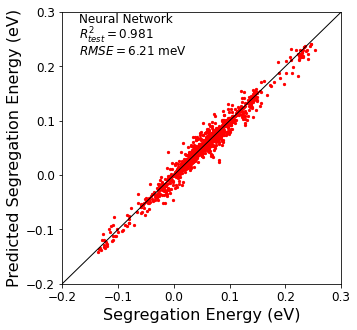

In [113]:
import matplotlib.pyplot as plt

axes = plt.gca()
fig=plt.gcf()
fig.set_size_inches(5,5)

xdum = np.linspace(-0.2,0.3,num=1000)
ydum= xdum

# X_test = torch.from_numpy(X_test)
# X_test = X_test.float()
# Y_test_pred = modelnnb(X_test)
# Y_test_pred = Y_test_pred.detach().numpy()
# Y_test_pred = Y_test_pred.squeeze()
# Y_test = Y_test.squeeze()

plt.plot(xdum, ydum, linewidth= 1, color='black')
plt.scatter(Y_test_pred, Y_test, s=5 , c='r')

axes.text(-0.17, 0.28, r'Neural Network', fontsize=12)
axes.text(-0.17, 0.25, r'$R^2_{test}=0.981$', fontsize=12)
axes.text(-0.17, 0.222, r'$RMSE=6.21$ meV', fontsize=12)


# plt.grid()
plt.xlabel('Segregation Energy (eV)',size=16)
plt.ylabel('Predicted Segregation Energy (eV)',size=16)
# plt.legend(prop={"size":20})
axes.set_xlim([-0.2,0.3])
axes.set_ylim([-0.2,0.3])
axes.tick_params(labelsize=12)
plt.show
# plt.savefig('modelpred.jpg', dpi=300, bbox_inches="tight")

# Extreme Gradient Boosted Decision Trees (XGBOOST)

In [116]:
#Extreme Gradient Boosted Decision Trees (XGBOOST) 

y_true = segE_all[:,1]
pos = feature[:,:3]
zpos = pos[:,2][:,np.newaxis]
ypos= pos[:,1][:,np.newaxis]
xpos= pos[:,0][:,np.newaxis]

feature1 = feature[:,3:]
# Separation of each feature:
f0= feature1[:,0][:,np.newaxis]
f1= feature1[:,1][:,np.newaxis]
f2= feature1[:,2][:,np.newaxis]
f3= feature1[:,3][:,np.newaxis]
f4= feature1[:,4][:,np.newaxis]
f5= feature1[:,5][:,np.newaxis]
f6= feature1[:,6][:,np.newaxis]
f7= feature1[:,7][:,np.newaxis]
f8= feature1[:,8][:,np.newaxis]
f9= feature1[:,9][:,np.newaxis]
f10= feature1[:,10][:,np.newaxis]
f11= feature1[:,11][:,np.newaxis]
f12= feature1[:,12][:,np.newaxis]
f13= feature1[:,13][:,np.newaxis]
f14= feature1[:,14][:,np.newaxis]
f15= feature1[:,15][:,np.newaxis]
f16= feature1[:,16][:,np.newaxis]
f17= feature1[:,17][:,np.newaxis]

# From Feature Elimination:
feature1 = np.concatenate([f0,f1,f2,f3,f4,f8,f9,f10,f11,f13,f14,f15,f16,xpos,ypos], axis=1)



n= feature1.shape[1]
print(n)

feature1 = feature1/np.max(feature1)

#Adding Interaction Terms:
feature2 = np.zeros([feature1.shape[0], n*n])  
for i in range(n):
    feature2[:,i*n:i*n+n] = feature1[:,i][:,np.newaxis]*feature1[:,:]

feature_space = np.concatenate([feature1, feature2], axis = 1)
feature_space = np.concatenate([np.ones((feature1.shape[0],1)), feature_space], axis = 1)

#feature_space = feature1

# print(feature_space.shape)   #
np.random.seed(10)
idx0 = np.random.permutation(np.arange(len(feature_space)))
feature_space = feature_space[idx0]
pos = pos[idx0]
y_true = y_true[idx0]

#divide data into training, crossvalildation and test sets.
X_train = feature_space[0:int(len(feature_space)*.7)]
#mean = np.mean(X_train, axis = 0)
#std = np.std(X_train, axis = 0)
#X_train = (X_train - mean)/std
X_temp = feature_space[int(len(feature_space)*.7):]
#X_temp = (X_temp - mean)/std
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]

Y_train = y_true[0:int(len(feature_space)*.7)]
Y_temp = y_true[int(len(feature_space)*.7):]
Y_cos = Y_temp[:int(len(X_temp)*.5)]
Y_test = Y_temp[int(len(X_temp)*.5):]
pos_test = pos[int(len(pos)*.85):,:]



###############################################

dtrain = xgb.DMatrix(X_train, Y_train)
dcos = xgb.DMatrix(X_cos, Y_cos)
dtest = xgb.DMatrix(X_test, Y_test)



15


In [119]:
# Hyperparameters:
np.random.seed(10)

xgboostb= xgb.XGBRegressor(learning_rate= 0.07729127514917492, objective='reg:squarederror',
                         booster='gbtree', max_depth=19,
                         reg_lambda = 0.25, reg_alpha= 1e-5,
                         subsample= 0.55 , colsample_bytree=0.8,
                         min_child_weight= 0.4, max_delta_step= 0.6)

# Training/Fitting:
modelxgbb= xgboostb.fit(X_train, Y_train)


Y_train_pred = modelxgbb.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(Y_train,Y_train_pred))
Y_cos_pred = modelxgbb.predict(X_cos)
rmse_cos = np.sqrt(mean_squared_error(Y_cos,Y_cos_pred))
Y_test_pred = modelxgbb.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(Y_test,Y_test_pred))


r2_train = modelxgbb.score(X_train, Y_train)
r2_cos = modelxgbb.score(X_cos, Y_cos)
r2_test = modelxgbb.score(X_test, Y_test)


print('r2_train:',r2_train)
print('r2_cos:',r2_cos)
print('r2_test:',r2_test)
print('rmse_train:',rmse_train)
print('rmse_cos:',rmse_cos)
print('rmse_test:',rmse_test, '\n')    


r2_train: 0.9994021056546163
r2_cos: 0.9733821164596217
r2_test: 0.971952617316474
rmse_train: 0.0011028527103208554
rmse_cos: 0.007310497350200033
rmse_test: 0.008013775441913442 



# Extra Trees

In [120]:
#EXTRA-TREES:

y_true = segE_all[:,1]
pos = feature[:,:3]
zpos = pos[:,2][:,np.newaxis]
ypos= pos[:,1][:,np.newaxis]
xpos= pos[:,0][:,np.newaxis]

feature1 = feature[:,3:]
# Separation of each feature:
f0= feature1[:,0][:,np.newaxis]
f1= feature1[:,1][:,np.newaxis]
f2= feature1[:,2][:,np.newaxis]
f3= feature1[:,3][:,np.newaxis]
f4= feature1[:,4][:,np.newaxis]
f5= feature1[:,5][:,np.newaxis]
f6= feature1[:,6][:,np.newaxis]
f7= feature1[:,7][:,np.newaxis]
f8= feature1[:,8][:,np.newaxis]
f9= feature1[:,9][:,np.newaxis]
f10= feature1[:,10][:,np.newaxis]
f11= feature1[:,11][:,np.newaxis]
f12= feature1[:,12][:,np.newaxis]
f13= feature1[:,13][:,np.newaxis]
f14= feature1[:,14][:,np.newaxis]
f15= feature1[:,15][:,np.newaxis]
f16= feature1[:,16][:,np.newaxis]
f17= feature1[:,17][:,np.newaxis]

feature1 = np.concatenate([f0,f1,f2,f3,f4,f8,f9,f10,f11,f13,f14,f15,f16,xpos,ypos], axis=1)


n= feature1.shape[1]

#Adding Interaction Terms
feature2 = np.zeros([feature1.shape[0], n*n])  
for i in range(n):
    feature2[:,i*n:i*n+n] = feature1[:,i][:,np.newaxis]*feature1[:,:]

feature_space = np.concatenate([feature1, feature2], axis = 1)
feature_space = np.concatenate([np.ones((feature1.shape[0],1)), feature_space], axis = 1)

np.random.seed(10)
idx0 = np.random.permutation(np.arange(len(feature_space)))
feature_space = feature_space[idx0]
pos = pos[idx0]
y_true = y_true[idx0]

#divide data into training, crossvalildation and test sets.
X_train = feature_space[0:int(len(feature_space)*.7)]
#mean = np.mean(X_train, axis = 0)
#std = np.std(X_train, axis = 0)
#X_train = (X_train - mean)/std
X_temp = feature_space[int(len(feature_space)*.7):]
#X_temp = (X_temp - mean)/std
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]

Y_train = y_true[0:int(len(feature_space)*.7)]
Y_temp = y_true[int(len(feature_space)*.7):]
Y_cos = Y_temp[:int(len(X_temp)*.5)]
Y_test = Y_temp[int(len(X_temp)*.5):]

In [84]:
# Hyperparameters:
np.random.seed(10)

xtreeb = ExtraTreesRegressor(n_estimators = 330, criterion='mse', max_features = 1.0,min_samples_split=2 )

# Training/Fitting:
model=  xtreeb.fit(X_train,Y_train)


Y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(Y_train,Y_train_pred))
Y_cos_pred = model.predict(X_cos)
rmse_cos = np.sqrt(mean_squared_error(Y_cos,Y_cos_pred))
Y_test_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(Y_test,Y_test_pred))


r2_train = model.score(X_train, Y_train)
r2_cos = model.score(X_cos, Y_cos)
r2_test = model.score(X_test, Y_test)


print('r2_train:',r2_train)
print('r2_cos:',r2_cos)
print('r2_test:',r2_test)
print('rmse_train:',rmse_train)
print('rmse_cos:',rmse_cos)
print('rmse_test:',rmse_test, '\n')    







r2_train: 0.9993654729978886
r2_cos: 0.9743224984003436
r2_test: 0.9717487304018174
rmse_train: 0.0011361360642878717
rmse_cos: 0.007180200079310737
rmse_test: 0.008042850264102794 



# Random Forests

In [121]:
#Random Forest:
y_true = segE_all[:,1]
pos = feature[:,:3]
zpos = pos[:,2][:,np.newaxis]
ypos= pos[:,1][:,np.newaxis]
xpos= pos[:,0][:,np.newaxis]
feature1 = feature[:,3:]

# Separation of each feature:
f0= feature1[:,0][:,np.newaxis]
f1= feature1[:,1][:,np.newaxis]
f2= feature1[:,2][:,np.newaxis]
f3= feature1[:,3][:,np.newaxis]
f4= feature1[:,4][:,np.newaxis]
f5= feature1[:,5][:,np.newaxis]
f6= feature1[:,6][:,np.newaxis]
f7= feature1[:,7][:,np.newaxis]
f8= feature1[:,8][:,np.newaxis]
f9= feature1[:,9][:,np.newaxis]
f10= feature1[:,10][:,np.newaxis]
f11= feature1[:,11][:,np.newaxis]
f12= feature1[:,12][:,np.newaxis]
f13= feature1[:,13][:,np.newaxis]
f14= feature1[:,14][:,np.newaxis]
f15= feature1[:,15][:,np.newaxis]
f16= feature1[:,16][:,np.newaxis]
f17= feature1[:,17][:,np.newaxis]

feature1 = np.concatenate([f0,f1,f2,f3,f4,f8,f9,f10,f11,f13,f14,f15,f16,xpos,ypos], axis=1)


# Adding Interaction Term:
n= feature1.shape[1]
#feature1 = feature1/np.max(feature1)   

#Adding Interaction Term:
feature2 = np.zeros([feature1.shape[0], n*n])  
for i in range(n):
    feature2[:,i*n:i*n+n] = feature1[:,i][:,np.newaxis]*feature1[:,:]

feature_space = np.concatenate([feature1, feature2], axis = 1)
feature_space = np.concatenate([np.ones((feature1.shape[0],1)), feature_space], axis = 1)


np.random.seed(10)
idx0 = np.random.permutation(np.arange(len(feature_space)))
feature_space = feature_space[idx0]
pos = pos[idx0]
y_true = y_true[idx0]

#divide data into training, crossvalildation and test sets.
X_train = feature_space[0:int(len(feature_space)*.7)]
# mean = np.mean(X_train, axis = 0)  ###
# std = np.std(X_train, axis = 0)     ###
# X_train = (X_train - mean)/std     ###
X_temp = feature_space[int(len(feature_space)*.7):]
# X_temp = (X_temp - mean)/std    ###
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]

Y_train = y_true[0:int(len(feature_space)*.7)]
Y_temp = y_true[int(len(feature_space)*.7):]
Y_cos = Y_temp[:int(len(X_temp)*.5)]
Y_test = Y_temp[int(len(X_temp)*.5):]
pos_test = pos[int(len(pos)*.85):,:]

In [122]:
# Hyperparameters:
np.random.seed(10)

rfb = RandomForestRegressor(n_estimators= 60, criterion='mse',
                          min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features = 0.48)
# Training/Fitting:
model=  rfb.fit(X_train,Y_train)



Y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(Y_train,Y_train_pred))
Y_cos_pred = model.predict(X_cos)
rmse_cos = np.sqrt(mean_squared_error(Y_cos,Y_cos_pred))
Y_test_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(Y_test,Y_test_pred))


r2_train = model.score(X_train, Y_train)
r2_cos = model.score(X_cos, Y_cos)
r2_test = model.score(X_test, Y_test)


print('r2_train:',r2_train)
print('r2_cos:',r2_cos)
print('r2_test:',r2_test)
print('rmse_train:',rmse_train)
print('rmse_cos:',rmse_cos)
print('rmse_test:',rmse_test, '\n')    







r2_train: 0.9945938995653412
r2_cos: 0.965418649855229
r2_test: 0.9651721149346153
rmse_train: 0.003316250639008328
rmse_cos: 0.008332611550315347
rmse_test: 0.00893006355800171 

